In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
def plot_conf_matrix(y_pred, y_true, title=None):
    """Helper Function to plot confustion matrix"""
    
    conf_mat = confusion_matrix(y_pred, y_true)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Fake", "Real"]],
                  columns = [i for i in ["Fake", "Real"]])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="Blues")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    if title:
        plt.title(f"{title} Confusion Matrix")
    plt.show()

# Read in Data and Preprocess

In [3]:
true_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/trueNews.csv")
fake_news_df = pd.read_csv("COVID19-FNIR/COVID19-FNIR/fakeNews.csv")
# Assign class columns and combine dataframes
fake_news_df["class"] = 0
true_news_df["class"] = 1
combined = pd.concat([fake_news_df, true_news_df], axis=0)

In [4]:
combined.shape

(7588, 15)

In [5]:
fake_news_df.shape

(3795, 12)

In [6]:
true_news_df.shape

(3793, 8)

In [7]:
# Subset data to just contain the text field and the class field
combined = combined[["Text", "class"]].reset_index(drop=True)
# Shuffle data
combined = combined.sample(frac = 1)

In [8]:
combined['Text'] = combined['Text'].str.replace('http\S+|www.\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('pic\S+|twitter.\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('#\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('@\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('Link:\S+', '', case=False)
combined['Text'] = combined['Text'].str.replace('[ \t]+$', '', case=False)
# remove front and ending blank spaces
combined = combined.replace({"^\s*|\s*$":""}, regex=True) 

def wordopt(text):
    """Formating of the text field """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    text = re.sub(' +', ' ', text)
    return text

combined["Text"] = combined["Text"].apply(wordopt)

In [9]:
combined[combined["class"]==1].iloc[2]["Text"]

'new covid cases in new york coming from people leaving home cuomo'

In [10]:
# for i in range(1000):
#     print(f"{i}: {combined[combined['class']==0].iloc[i]['Text']}")

In [11]:
combined[combined["class"]==0].iloc[540]["Text"]

'the cdc now says that the coronavirus can survive on surfaces for up to days '

In [13]:
combined[combined["class"]==1].iloc[540]["Text"]

'follow this link to download the pandemic notebook a handy guide from the hindu on understanding the and staying protected against covid '

In [14]:
combined.head()

,Text,class
148,a monkey has been infected with coronavirus in...,0
6834,perspective will police enforce covid stay hom...,1
4887,who says looking into reports of some covid pa...,1
6283,new covid cases in new york coming from people...,1
6959,the indian is expected to contract by in this ...,1


In [15]:
# Set X and y variables
X = combined["Text"]
y = combined["class"]

In [16]:
# Split data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 

vectorization = TfidfVectorizer()
X_train = vectorization.fit_transform(X_train)
X_test = vectorization.transform(X_test)

# Model 1: Naive Bayes Model

In [18]:
from sklearn.naive_bayes import MultinomialNB


nb_model = MultinomialNB()
# Fit model 
nb_model.fit(X_train, y_train)
# Predict 
y_pred = nb_model.predict(X_test)

In [19]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8961518186610438


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       933
           1       0.90      0.89      0.90       964

    accuracy                           0.90      1897
   macro avg       0.90      0.90      0.90      1897
weighted avg       0.90      0.90      0.90      1897



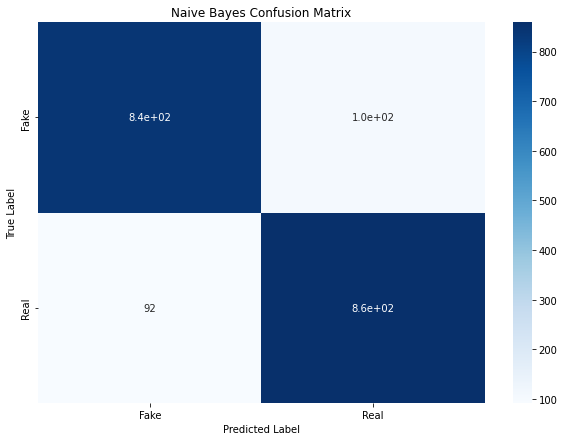

In [21]:
plot_conf_matrix(y_pred, y_test, title="Naive Bayes")

In [22]:
# 
params = {
    "alpha": [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10],
    "fit_prior": (True, False),
}
gs_clf = GridSearchCV(MultinomialNB(), params, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

In [28]:
# gs_clf.cv_results_

In [29]:
y_pred = gs_clf.predict(X_test)

In [30]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.897206114918292


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       933
           1       0.90      0.90      0.90       964

    accuracy                           0.90      1897
   macro avg       0.90      0.90      0.90      1897
weighted avg       0.90      0.90      0.90      1897



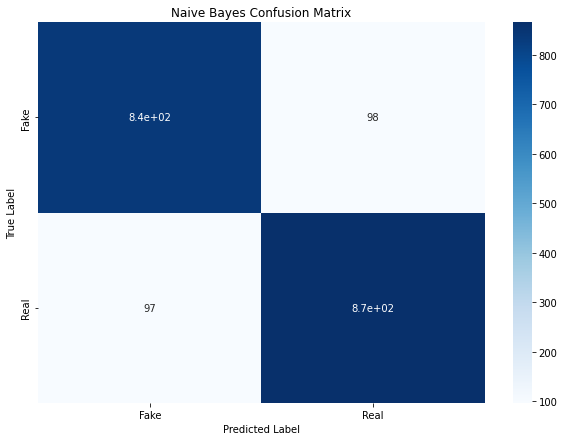

In [32]:
plot_conf_matrix(y_pred, y_test, title="Naive Bayes")

# Model 2: Gradient Boosting Classifier

In [239]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_model = GradientBoostingClassifier()
# Fit model 
gbt_model.fit(X_train, y_train)
# Predict 
y_pred = gbt_model.predict(X_test)

In [240]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8508170795993675


In [241]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       961
           1       0.83      0.87      0.85       936

    accuracy                           0.85      1897
   macro avg       0.85      0.85      0.85      1897
weighted avg       0.85      0.85      0.85      1897



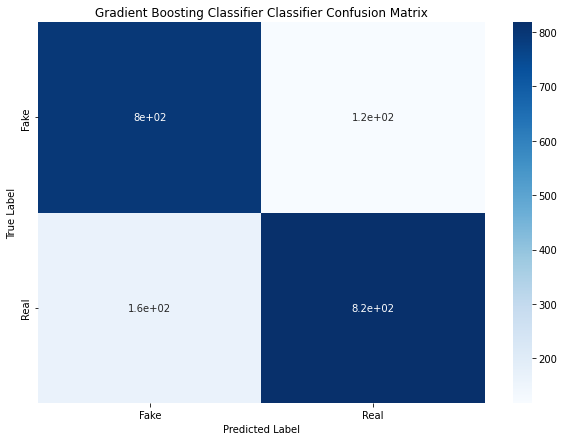

In [242]:
plot_conf_matrix(y_pred, y_test, title="Gradient Boosting Classifier Classifier")

In [243]:
%%time
params = {
    "loss": ["deviance", "exponential"],
    "learning_rate": [0.001, 0.01, 0.1, 1, 2],
    "n_estimators": [10, 50, 100],
    "subsample": [0.5, 0.75, 1.0],
}

gs_clf = GridSearchCV(GradientBoostingClassifier(), params, n_jobs=-1, scoring='accuracy', verbose=10)
  
gs_clf = gs_clf.fit(X_train, y_train)
# Predict 
y_pred = gs_clf.predict(X_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5; 3/90] START learning_rate=0.001, loss=deviance, n_estimators=10, subsample=1.0
[CV 1/5; 3/90] END learning_rate=0.001, loss=deviance, n_estimators=10, subsample=1.0;, score=0.827 total time=   0.5s
[CV 2/5; 5/90] START learning_rate=0.001, loss=deviance, n_estimators=50, subsample=0.75
[CV 2/5; 5/90] END learning_rate=0.001, loss=deviance, n_estimators=50, subsample=0.75;, score=0.839 total time=   2.1s
[CV 4/5; 7/90] START learning_rate=0.001, loss=deviance, n_estimators=100, subsample=0.5
[CV 4/5; 7/90] END learning_rate=0.001, loss=deviance, n_estimators=100, subsample=0.5;, score=0.831 total time=   3.8s
[CV 2/5; 10/90] START learning_rate=0.001, loss=exponential, n_estimators=10, subsample=0.5
[CV 2/5; 10/90] END learning_rate=0.001, loss=exponential, n_estimators=10, subsample=0.5;, score=0.825 total time=   0.3s
[CV 4/5; 10/90] START learning_rate=0.001, loss=exponential, n_estimators=10, subsample=0.5
[CV 4/

In [246]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8687401159725883


In [247]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       961
           1       0.86      0.87      0.87       936

    accuracy                           0.87      1897
   macro avg       0.87      0.87      0.87      1897
weighted avg       0.87      0.87      0.87      1897



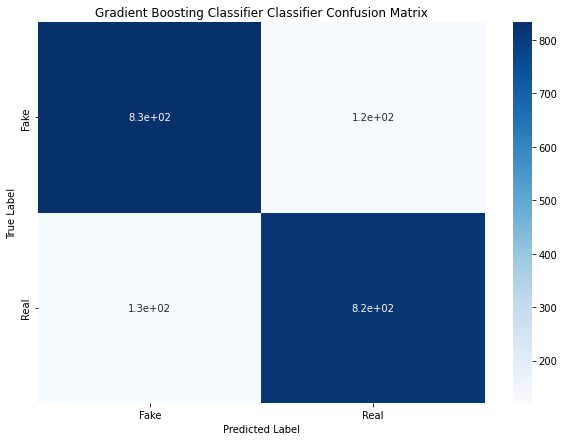

In [248]:
plot_conf_matrix(y_pred, y_test, title="Gradient Boosting Classifier Classifier")

# Model 3: Random Forest Classifier

In [249]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
# Fit model 
rf_model.fit(X_train, y_train)
# Predict 
y_pred = rf_model.predict(X_test)

In [250]:
params = {
    "n_estimators": [10, 50, 100, 200],
    "min_samples_leaf": [1, 2, 4],
}
gs_clf = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
# Predict 
y_pred = gs_clf.predict(X_test)

In [251]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9109119662625198


In [252]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       961
           1       0.90      0.92      0.91       936

    accuracy                           0.91      1897
   macro avg       0.91      0.91      0.91      1897
weighted avg       0.91      0.91      0.91      1897



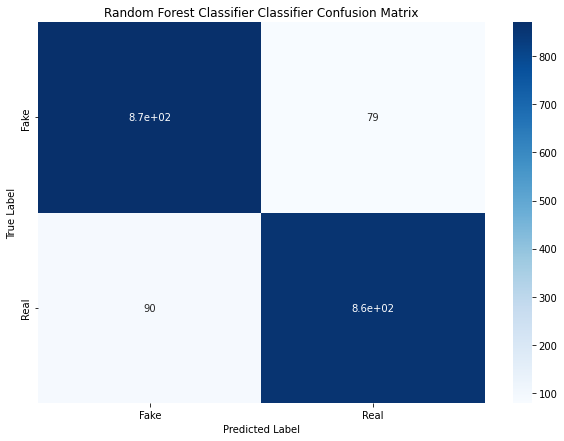

In [253]:
plot_conf_matrix(y_pred, y_test, title="Random Forest Classifier Classifier")

# LSTM